# **Data Download Link**
https://data.mendeley.com/datasets/rscbjbr9sj/2/files/f12eaf6d-6023-432f-acc9-80c9d7393433/

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/Pneumonia_Prediction/ChestXRay2017.zip -d /content/ > /dev/null

# Overview

![imgae](https://i.imgur.com/jZqpV51.png)

The normal chest X-ray (left panel) depicts clear lungs without any areas of abnormal opacification in the image. Bacterial pneumonia (middle) typically exhibits a focal lobar consolidation, in this case in the right upper lobe (white arrows), whereas viral pneumonia (right) manifests with a more diffuse ‘‘interstitial’’ pattern in both lungs.


---

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.



# Import Libraries

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import backend as K

import os
import cv2
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image, ImageOps
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

# Hyperparameter
In machine learning, a hyperparameter is a parameter whose value is set before the learning process begins.

*   IMG_WIDTH  : image width
*   IMG_HEIGHT : image height
*   EPOCHS : Hyperparameter of gradient descent that controls the number of complete passes through the training dataset.
*   BATCH_SIZE : Hyperparameter of gradient descent that controls the number of training samples to work through before the model’s internal parameters are updated.



In [4]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
EPOCHS = 3
BATCH_SIZE = 128

# File directory



*   train : contains the training data/images 
*   test : this contains the data that we use to test the model once it has learned the relationships between the images and their label (Pneumonia/Not-Pneumonia)


In [5]:
os.listdir('chest_xray')

['.DS_Store', 'train', 'test']

In [6]:
print(len(glob('chest_xray/train/*/*')))
print(len(glob('chest_xray/test/*/*')))

5232
624


# Validation data set
The sample of data used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters. The evaluation becomes more biased as skill on the validation dataset is incorporated into the model configuration.

In [7]:
original_dataset_dir = 'chest_xray'
base_dir ='chest_xray_postprocessed'
os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
val_dir = os.path.join(base_dir, 'val')
os.mkdir(val_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

train_pneumonia_dir = os.path.join(train_dir, 'pneumonia')
os.mkdir(train_pneumonia_dir)

train_normal_dir = os.path.join(train_dir, 'normal')
os.mkdir(train_normal_dir)

val_pneumonia_dir = os.path.join(val_dir, 'pneumonia')
os.mkdir(val_pneumonia_dir)

val_normal_dir = os.path.join(val_dir, 'normal')
os.mkdir(val_normal_dir)

test_pneumonia_dir = os.path.join(test_dir, 'pneumonia')
os.mkdir(test_pneumonia_dir)

test_normal_dir = os.path.join(test_dir, 'normal')
os.mkdir(test_normal_dir)

In [8]:
import shutil

paths_pneumonia = glob(original_dataset_dir +'/train/PNEUMONIA/*')
paths_normal = glob(original_dataset_dir+'/train/NORMAL/*')

fname_pneumonia = [x.split('/')[-1] for x in paths_pneumonia]
fname_normal = [x.split('/')[-1] for x in paths_normal]

def train_val_data_split(pneumonia_list, normal_list, validation_split=0.1):
    
    n_pneumonia = len(pneumonia_list)
    n_normal = len(normal_list)
    
    shuffle_idx_pneumonia = [x for x in range(n_pneumonia)]
    shuffle_idx_normal = [x for x in range(n_normal)]
    
    num_train_pneumonia = int((1-validation_split)*n_pneumonia)
    num_val_pneumonia = n_pneumonia - num_train_pneumonia
    
    num_train_normal = int((1-validation_split)*n_normal)
    num_val_normal = n_normal - num_train_normal
    
    for i in range(num_train_pneumonia):
        src = os.path.join(original_dataset_dir+'/train/PNEUMONIA/', pneumonia_list[i])
        dst = os.path.join(train_pneumonia_dir, pneumonia_list[i])
        shutil.copyfile(src,dst)
        
    for i in range(num_train_pneumonia,n_pneumonia):
        src = os.path.join(original_dataset_dir+'/train/PNEUMONIA/', pneumonia_list[i])
        dst = os.path.join(val_pneumonia_dir, pneumonia_list[i])
        shutil.copyfile(src,dst)
        
    for i in range(num_train_normal):
        src = os.path.join(original_dataset_dir+'/train/NORMAL/', normal_list[i])
        dst = os.path.join(train_normal_dir, normal_list[i])
        shutil.copyfile(src,dst)
        
    for i in range(num_train_normal,n_normal):
        src = os.path.join(original_dataset_dir+'/train/NORMAL/', normal_list[i])
        dst = os.path.join(val_normal_dir, normal_list[i])
        shutil.copyfile(src,dst)

train_val_data_split(fname_pneumonia, fname_normal, validation_split=0.1)

In [9]:
test_data = []
test_labels = []

def test_data_copy():  
    test_data_pneumonia = glob(original_dataset_dir+'/test/PNEUMONIA/*')
    test_data_normal = glob(original_dataset_dir+'/test/NORMAL/*')
    
    test_fname_pneumonia = [x.split('/')[-1] for x in test_data_pneumonia]
    test_fname_normal = [x.split('/')[-1] for x in test_data_normal]
    
    n_pneumonia = len(test_fname_pneumonia)
    n_normal = len(test_fname_normal)
    
    for i in range(n_pneumonia):
      src = os.path.join(original_dataset_dir+'/test/PNEUMONIA/', test_fname_pneumonia[i])
      dst = os.path.join(test_pneumonia_dir, test_fname_pneumonia[i])
      shutil.copyfile(src,dst)
        
    for i in range(n_normal):
      src = os.path.join(original_dataset_dir+'/test/NORMAL/', test_fname_normal[i])
      dst = os.path.join(test_normal_dir, test_fname_normal[i])
      shutil.copyfile(src,dst)

    for cond in ['/normal/', '/pneumonia/']:
        for img in (os.listdir(test_dir + cond)):
            img = plt.imread(test_dir + cond + img)
            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/normal/':
                label = 0
            elif cond=='/pneumonia/':
                label = 1
            test_data.append(img)
            test_labels.append(label)        

test_data_copy()
test_data = np.array(test_data)
test_labels = np.array(test_labels)

# Categories
*   NORMAL: These are the samples that describe the normal (no pneumonia) case.
*   PNEUMONIA: This directory contains those samples that are the pneumonia cases.


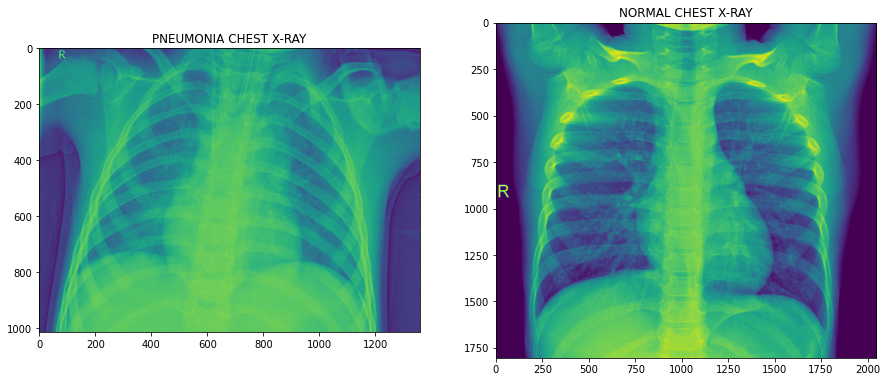

In [10]:
plt.figure(1, figsize = (15 , 7))
plt.subplot(1 , 2 , 1)
img = glob(train_dir+"/pneumonia/*.jpeg") #Getting an image in the PNEUMONIA folder
img = np.asarray(plt.imread(img[0]))
plt.title('PNEUMONIA CHEST X-RAY')
plt.imshow(img)

plt.subplot(1 , 2 , 2)
img = glob(train_dir+"/normal/*.jpeg") #Getting an image in the NORMAL folder
img = np.asarray(plt.imread(img[0]))
plt.title('NORMAL CHEST X-RAY')
plt.imshow(img)

plt.show()

# Input Shape


In [11]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, IMG_WIDTH, IMG_HEIGHT)
else:
    input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)

# Generate batches of tensor image data with real-time data augmentation.

# Image Preprocessing

![image](https://software.intel.com/sites/default/files/managed/9f/6b/image-data-preprocessing-rescaling2.JPG)  
**rescale** :  255 is the maximin pixel value. Rescale 1./255 is to transform every pixel value from range [0,255] -> [0,1].  
And the benefits are:   
*   **Treat all images in the same manner** : some images are high pixel range, some are 
low pixel range. The images are all sharing the same model, weights and learning rate. The high range image tends to create stronger loss while low range create weak loss, the sum of them will all contribute the back propagation update. But for visual understanding, you care about the contour more than how strong is the contrast as long as the contour is reserved. Scaling every images to the same range [0,1] will make images contributes more evenly to the total loss. In other words, a high pixel range cat image has one vote, a low pixel range cat image has one vote, a high pixel range dog image has one vote, a low pixel range dog image has one vote... this is more like what we expect for training a model for dog/cat image classifier. Without scaling, the high pixel range images will have large amount of votes to determine how to update weights. For example, black/white cat image could be higher pixel range than pure black cat image, but it just doesn't mean black/white cat image is more important for training.
*   **Using typical learning rate** : when we reference learning rate from other's work, we can directly reference to their learning rate if both works do the scaling preprocessing over images data set. Otherwise, higher pixel range image results higher loss and should use smaller learning rate, lower pixel range image will need larger learning rate.  
  

---
    
  
![image](https://software.intel.com/sites/default/files/managed/ad/c6/image-data-preprocessing-shearing.JPG)  
**shear_range** : shearing displaces each point in the vertical direction by an amount proportional to its distance from an edge of the image.


---


![image](https://software.intel.com/sites/default/files/managed/14/cb/image-data-preprocessing-zoom3.JPG)  
**zoom_range** : he zoom_range parameter controls the zooming factor.


---
![image](https://software.intel.com/sites/default/files/managed/74/2f/image-data-preprocessing-vertical-flip.JPG)  
**horizontal_flip** : Randomly flip inputs horizontally.


In [12]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1. / 255)

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [13]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary')

Found 4708 images belonging to 2 classes.
Found 524 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Model
**Convolutional Neural Networks**

They use filters to be able to successfully capture the Spatial and Temporal dependencies in an image. 


![https://cdn-images-1.medium.com/max/1600/1*ZCjPUFrB6eHPRi4eyP6aaA.gif](https://cdn-images-1.medium.com/max/1600/1*ZCjPUFrB6eHPRi4eyP6aaA.gif)


**Convolutional Layers**

keras.layers.Conv2D(number_of_filters, filter_size, activation=None)


**Filters/Kernels**

The feature capturing fields/windows. During training, your ConvNet would learn the best filters necessary for accomplishing its objective.

Not much different from the IG or other photo editing filters.  



![https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/06/28011851/conv.gif](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/06/28011851/conv.gif)


![https://mlnotebook.github.io/img/CNN/convSobel.gif](https://mlnotebook.github.io/img/CNN/convSobel.gif)


![https://ujwlkarn.files.wordpress.com/2016/08/giphy.gif?w=364](https://ujwlkarn.files.wordpress.com/2016/08/giphy.gif?w=364)

**Pooling Layer**

Reduces the spatial size of Captured Features (*Feature Maps*) by extracting dominant features. 


**Max Pooling** returns the maximum value from the portion of the image covered by the Filter.



![https://developers.google.com/machine-learning/practica/image-classification/images/maxpool_animation.gif](https://developers.google.com/machine-learning/practica/image-classification/images/maxpool_animation.gif)

In [14]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 61, 61, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       7

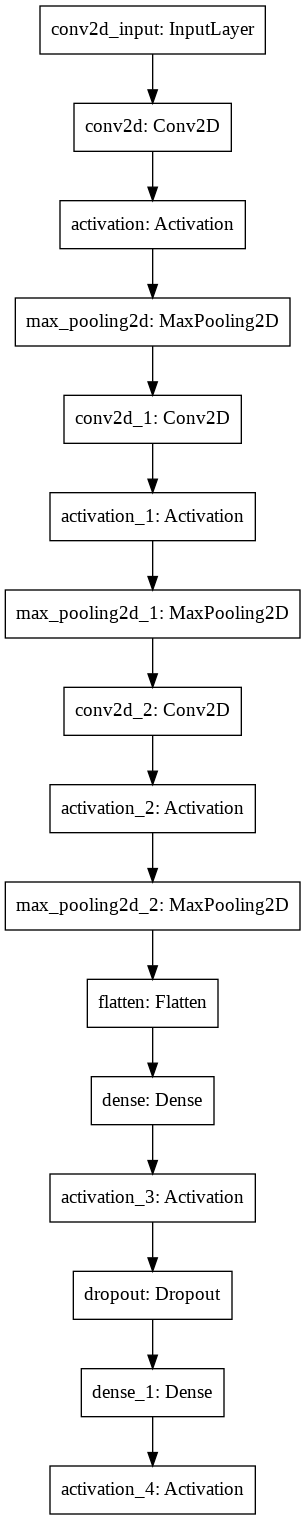

In [16]:
tf.keras.utils.plot_model(model)

# Compile


*   loss : Cross-entropy loss increases as the predicted probability diverges from the actual label. Notice that when actual label is 1 (y(i) = 1), second half of function disappears whereas in case actual label is 0 (y(i) = 0) first half is dropped off. In short, we are just multiplying the log of the actual predicted probability for the ground truth class. An important aspect of this is that cross entropy loss penalizes heavily the predictions that are confident but wrong.  
![image](https://miro.medium.com/max/1609/1*zi1wKAAGGt1Bn6mqo2MSFw.png)  


*   optimizer : Adam can be looked at as a combination of RMSprop and Stochastic Gradient Descent with momentum. It uses the squared gradients to scale the learning rate like RMSprop and it takes advantage of momentum by using moving average of the gradient instead of gradient itself like SGD with momentum.  
![image](https://miro.medium.com/max/462/1*X9gB3l_Wh5owNPCUsaYQVQ.png)

* metrics : A metric is a function that is used to judge the performance of your model. Metric functions are to be supplied in the metrics parameter when a model is compiled.



In [17]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Training

In [18]:
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // BATCH_SIZE,
                    epochs=EPOCHS,
                    shuffle=True,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // BATCH_SIZE)

Epoch 1/3
36/36 [==============================] - 66s 2s/step - loss: 0.7076 - accuracy: 0.7199 - val_loss: 0.2966 - val_accuracy: 0.8848
Epoch 2/3
36/36 [==============================] - 59s 2s/step - loss: 0.3023 - accuracy: 0.8733 - val_loss: 0.1874 - val_accuracy: 0.9199
Epoch 3/3
36/36 [==============================] - 59s 2s/step - loss: 0.2430 - accuracy: 0.8973 - val_loss: 0.1453 - val_accuracy: 0.9434


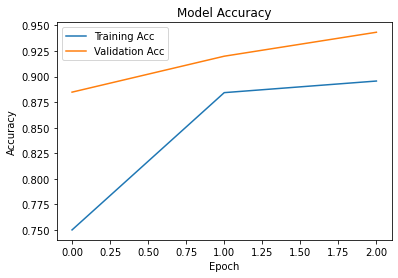

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Validation Acc'], loc='upper left')
plt.show()

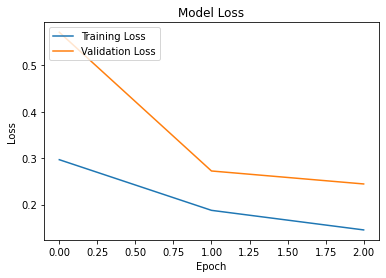

In [20]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
plt.show()

* Accuracy : Classification Accuracy is what we usually mean, when we use the term accuracy. It is the ratio of number of correct predictions to the total number of input samples.   
![image](https://miro.medium.com/max/373/1*yRa2inzTnyASJOre93ep3g.gif)

* Precision : It is the number of correct positive results divided by the number of positive results predicted by the classifier.  
![image](https://miro.medium.com/max/365/1*wMIDfGwT9bA6HezvYhdbpQ.gif)

* Recall : It is the number of correct positive results divided by the number of all relevant samples  
![image](https://miro.medium.com/max/371/1*gIlQMZBPjtUHWkwOhRG3KA.gif)

* F1 Score : F1 Score is the Harmonic Mean between precision and recall. The range for F1 Score is [0, 1]. It tells you how precise your classifier is (how many instances it classifies correctly), as well as how robust it is (it does not miss a significant number of instances).  
High precision but lower recall, gives you an extremely accurate, but it then misses a large number of instances that are difficult to classify. The greater the F1 Score, the better is the performance of our model.     
![image](https://miro.medium.com/max/191/1*_pYttqYh8w-EpLxMi84H8A.gif)

CONFUSION MATRIX ------------------


<Figure size 432x288 with 0 Axes>

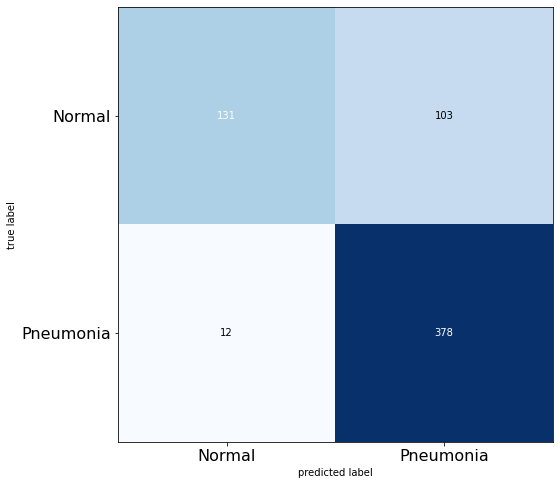


TEST METRICS ----------------------
Accuracy: 81.57051282051282%
Precision: 78.5862785862786%
Recall: 96.92307692307692%
F1-score: 86.796785304248


In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
plt.figure()
plot_confusion_matrix(cm,figsize=(10,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


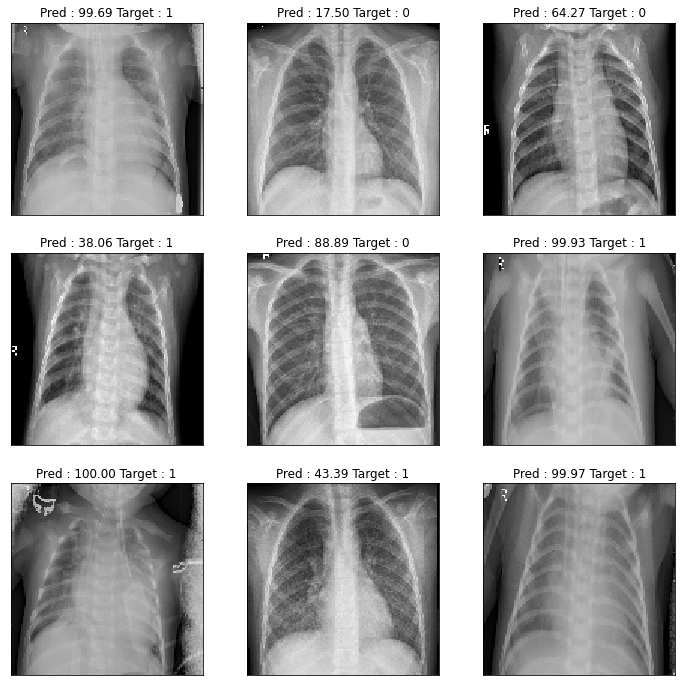

In [22]:
fig, ax = plt.subplots(figsize=(12, 12))
acc = model.predict(test_data) 
for i in range(9):
  rand= np.random.randint(0,len(test_data))
  plt.subplot(3, 3, i+1)
  image = np.expand_dims(test_data[rand], axis=0)
  classes = model.predict_classes(image)
  if classes[0][0] == 0:
    plt.imshow(test_data[rand], interpolation='nearest')
    plt.title('Pred : %.2f Target : %d' %(preds[rand] * 100, test_labels[rand]))
  else:
    plt.imshow(test_data[rand], interpolation='nearest')
    plt.title('Pred : %.2f Target : %d' %(preds[rand] * 100, test_labels[rand]))
  plt.xticks([])
  plt.yticks([])

plt.show()

In [23]:
layer_outputs = [layer.output for layer in model.layers[:len(model.layers)]]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

In [24]:
rand= np.random.randint(0,len(test_data))
image = np.expand_dims(test_data[rand], axis=0)
activations = activation_model.predict(image)
first_layer_activation = activations[0]

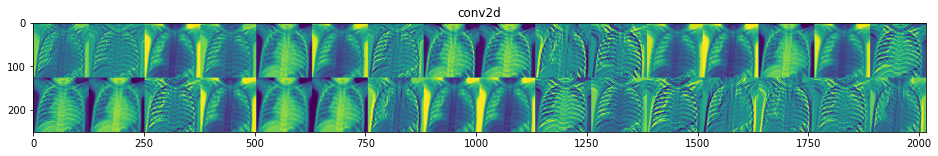

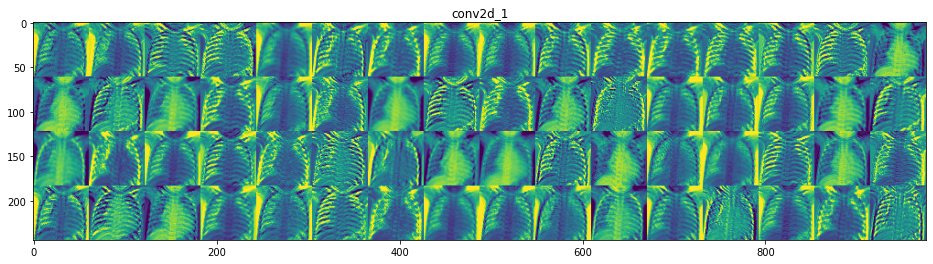

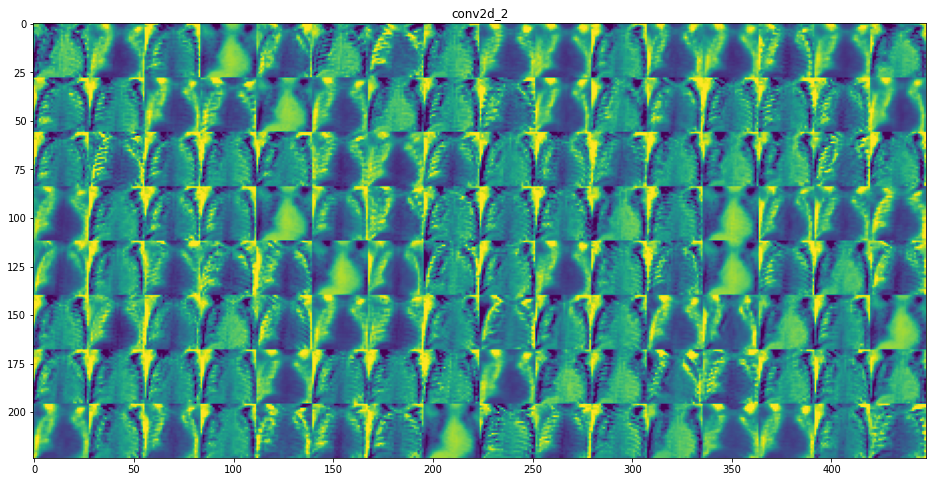

In [25]:
layer_names = []
for layer in model.layers[:-1]:
    layer_names.append(layer.name) 
images_per_row = 16
zipped_layers = zip(layer_names, activations)
for layer_name, layer_activation in zipped_layers: #this loop     
    if layer_name.startswith('conv'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


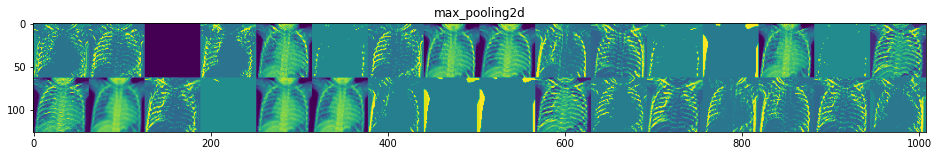

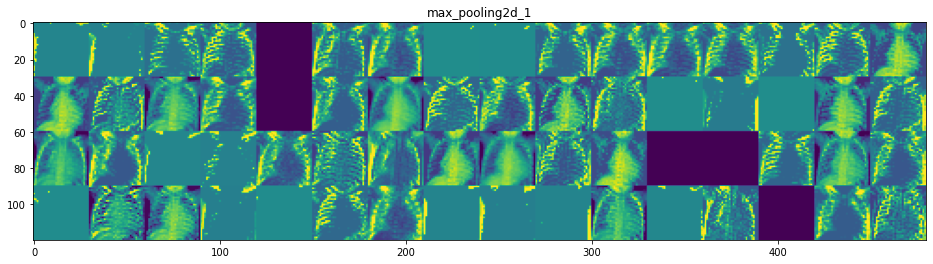

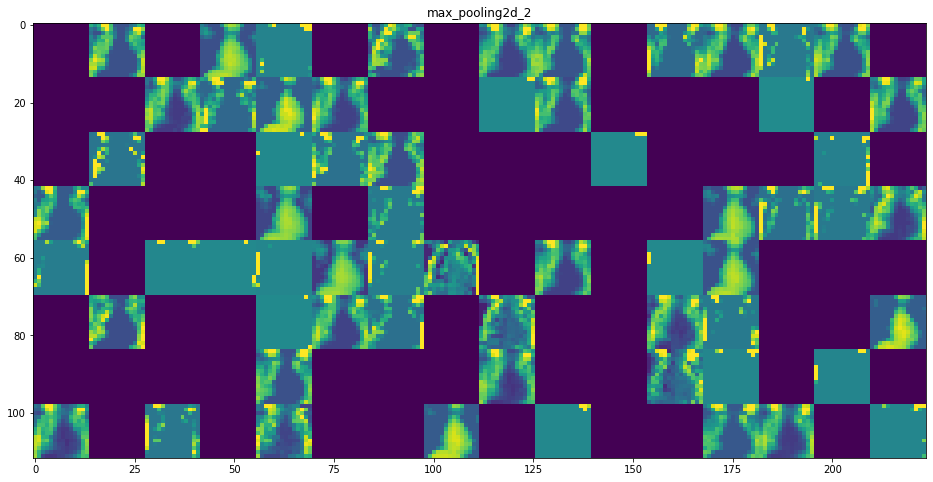

In [26]:
layer_names = []
for layer in model.layers[:-1]:
    layer_names.append(layer.name) 
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    if layer_name.startswith('max'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')